# Figures for manuscript

## Figure List
1. BrainSense Artifact Creation
2. Sync Artifact Comparison
3. Spikedrop
4. Manual annotations
5. Tapping
6. Pipeline

7. 0.1 reduction
8. robustness of 2 artifacts

In [1]:
import sys
import os

# Get the path to the project root (one level up from the notebook)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root, NOT 'source', to sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# print the sys.path
print(sys.path)

['/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/lenasalzmann/dev/dbs-eeg-sync/.venv/lib/python3.12/site-packages', '/Users/lenasalzmann/dev/dbs-eeg-sync']


In [2]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, resample_poly
import plotly.graph_objects as go
from dbs_eeg_sync.data_loader import load_eeg_data, open_json_file, select_recording, read_time_domain_data
from dbs_eeg_sync.sync_artifact_finder import detect_eeg_sync_artifact, detect_dbs_sync_artifact
from dbs_eeg_sync.power_calculator import compute_samplewise_eeg_power
from dbs_eeg_sync.plotting import apply_publication_style, EEG_COLOR, DBS_COLOR
from dbs_eeg_sync.synchronizer import cut_data_at_sync, synchronize_data


Use P4-2004 for EEG and P4-2001 for D and E

In [3]:
sub_ids = [ 'P4-2001', 'P4-2002', 'P4-2003', 'P4-2004', 'P4-2005', 'P4-2007', 'P4-2008', 'P4-2009', 'P4-2010', 'P4-2011']
sub_id = 'P4-2001'
block = 'baseline'
dataDir_server = r"/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB"

In [4]:
file_info_dbs = [
    {"sub_id": "P4-2001", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2001/RawData/DBS/Report_Json_Session_Report_20240610T162159.json"},
    {"sub_id": "P4-2002", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2002/RawData/DBS/Report_Json_Session_Report_20240719T121230.json"},
    {"sub_id": "P4-2003", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2003/RawData/DBS/Report_Json_Session_Report_20241025T120701.json"},
    {"sub_id": "P4-2004", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2004/RawData/DBS/Report_Json_Session_Report_20241028T163753.json"},
    {"sub_id": "P4-2005", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2005/RawData/DBS/Report_Json_Session_Report_20241029T170455.json"},
    {"sub_id": "P4-2007", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2007/RawData/DBS/Report_Json_Session_Report_20250110T112532.json"},
    {"sub_id": "P4-2008", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2008/RawData/DBS/Report_Json_Session_Report_20250310T113259.json"},
    {"sub_id": "P4-2009", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2009/RawData/DBS/Report_Json_Session_Report_20250314T131338.json"},
    {"sub_id": "P4-2010", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2010/RawData/DBS/Report_Json_Session_Report_20250425T161748.json"},
    {"sub_id": "P4-2011", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2011/RawData/DBS/Report_Json_Session_Report_20250520T165018.json"},
    {"sub_id": "P4-2012", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2012/RawData/DBS/Report_Json_Session_Report_20250710T122046.json"},
]

Load Data 

In [5]:
# Load EEG data
eeg_file = os.path.join(dataDir_server, sub_id, 'ProcessedData', 'EEG', block, block + '_prep.set')
eeg_data, sfreq = load_eeg_data(eeg_file)

In [6]:
# Load DBS

# get file_path from file_info_dbs
if block == 'baseline':
    block_number = 0
# add block indexing later
dbs_path = [file for file in file_info_dbs if file['sub_id'] == sub_id][block_number]['file_path']

json_data = open_json_file(dbs_path)
dbs_data = read_time_domain_data(json_data, block_number) 
dbs_signal =  dbs_data["TimeDomainData"].values
dbs_fs = dbs_data["SampleRateInHz"][0]

In [7]:
# print the length of the original recordings for eeg and dbs
print(f'Length of original eeg: {len(eeg_data.get_data()[0])/sfreq} seconds')
print(f'Length of original dbs: {len(dbs_data["TimeDomainData"].values)/dbs_fs} seconds')

# and in samples
print(f'Length of original eeg: {len(eeg_data.get_data()[0])} samples')
print(f'Length of original dbs: {len(dbs_data["TimeDomainData"].values)} samples')


Length of original eeg: 191.072 seconds
Length of original dbs: 184.0 seconds
Length of original eeg: 382144 samples
Length of original dbs: 46000 samples


### 0. Overview: Run Sync Detection

EEG

In [8]:
# EEG
if sub_id == 'P4-2007':
    channel, eeg_sync_idx, eeg_sync_s, result, smoothed_power = detect_eeg_sync_artifact(eeg_data, freq_low=110, freq_high=120, plot=False, save_dir=None, sub_id=sub_id, block=block)
else:
    channel, eeg_sync_idx, eeg_sync_s, result, smoothed_power = detect_eeg_sync_artifact(eeg_data, freq_low=120, freq_high=130, plot=False, save_dir=None, sub_id=sub_id, block=block)

In [9]:
# print length of smoothed_power
print(f'Length of smoothed_power: {len(smoothed_power)} samples')
print(f'Length of smoothed_power: {len(smoothed_power)/sfreq} seconds')

Length of smoothed_power: 382144 samples
Length of smoothed_power: 191.072 seconds


In [10]:
# extract the smoothed_power samples around +- 0.5s around the artifact for the plot
eeg_power_artifact = smoothed_power[eeg_sync_idx-int(eeg_data.info['sfreq']/2):eeg_sync_idx+int(eeg_data.info['sfreq']/2)]
eeg_times_artifact = np.arange(len(eeg_power_artifact)) / eeg_data.info['sfreq']

In [11]:
# check the downsampling of the sync index
print(f'Sync index: {eeg_sync_idx} samples')
print(f'Sync index: {eeg_sync_idx/eeg_data.info["sfreq"]} seconds')


Sync index: 37041 samples
Sync index: 18.5205 seconds


DBS

In [12]:
# Find DBS sync artifact
dbs_peak_idx, dbs_peak_s = detect_dbs_sync_artifact(dbs_signal, dbs_fs, save_dir=None, sub_id=sub_id, block=block)
# investigate the artifact
dbs_artifact = dbs_signal[dbs_peak_idx-int(dbs_fs/2):dbs_peak_idx+int(dbs_fs/2)]
dbs_times = np.arange(len(dbs_artifact)) / dbs_fs

### 1. Plot the first couple samples of the raw signals 

EEG

In [13]:
# select the following channels from the eeg data

# eeg_data_ch_selected = eeg_data.copy().pick_channels(['Pz', 'Cz', 'Fz', 'POz', 'CPz'])
eeg_data_ch_selected = eeg_data.copy().pick_channels(['Cz', 'Fz', 'POz'])

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Fig. 6a

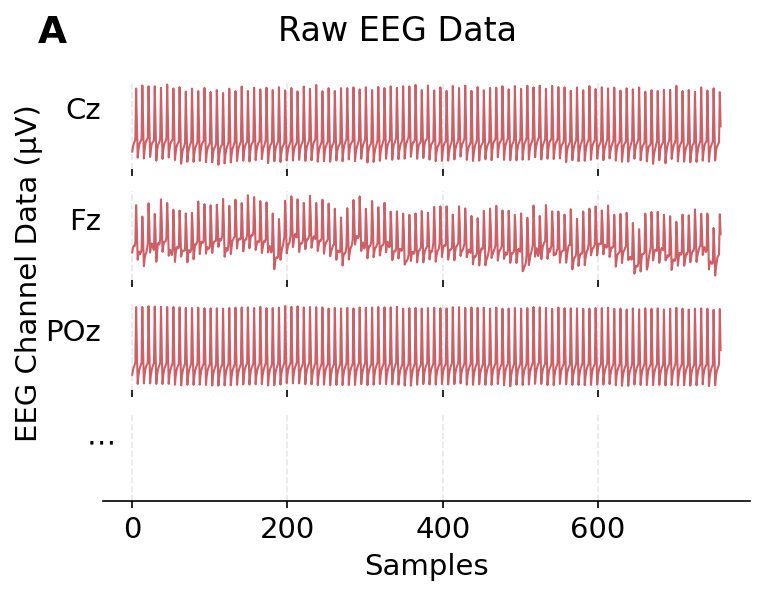

In [14]:
# extract the first 30 seconds of the eeg data for 5 channels

fs_eeg_org = int(eeg_data_ch_selected.info['sfreq'])
n_samples = int(0.38 * fs_eeg_org)  # 0.38 gives the correct length of the signal for the publication figure

channel_data, times = eeg_data_ch_selected[:5, 1:n_samples]   

eeg_sample_indices = np.arange(channel_data.shape[1])

n_channels = channel_data.shape[0]

fig_height_per_channel = 1

fig, axes = plt.subplots(n_channels + 1, 1, figsize=(5, fig_height_per_channel * (n_channels + 1)), sharex=True)

# Plot EEG channels

scale_factor = 0.8

for i in range(n_channels):
    # current_channel = channel_data[i]*1e6   # convert to uV
    current_channel = channel_data[i]
    ax = axes[i]
    ax.plot(eeg_sample_indices, current_channel, color=EEG_COLOR)  # sample indices

    ax.set_ylabel(eeg_data_ch_selected.ch_names[i], rotation=0, labelpad=1, fontsize=14, ha="right")
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    if i != n_channels:
        ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x', labelsize=14)
    ax.grid(True, linestyle="--", alpha=0.3)

# Empty subplot
axes[-1].set_ylabel("⋯", rotation=0, labelpad=1, fontsize=14, ha="center")
axes[-1].set_yticks([])
axes[-1].spines['top'].set_visible(False)
axes[-1].spines['right'].set_visible(False)
axes[-1].spines['left'].set_visible(False)
axes[-1].spines['bottom'].set_visible(True)
axes[-1].tick_params(axis='x', labelsize=14)
axes[-1].grid(True, linestyle="--", alpha=0.3)  # optional grid

# Labels
# axes[-1].set_xlabel("Time (s)", fontsize=14)
axes[-1].set_xlabel("Samples", fontsize=14)
fig.suptitle("Raw EEG Data", fontsize=16)

plt.tight_layout()
fig.text(-0.01, 0.55, "EEG Channel Data (μV)", va='center', rotation='vertical', fontsize=14)  # Shared y-label

# Add capital letter A to top left
fig.text(0.02, 0.98, 'A', transform=fig.transFigure, fontsize=18, fontweight='bold', va='top', ha='left')

# save plot as pdf in outputs/plots
plt.savefig(f"outputs/plots/fig6a_raw_eeg.pdf", bbox_inches='tight')

plt.show()

DBS

In [15]:
# select the whole dbs data

dbs_selected_data = dbs_data["TimeDomainData"].values

# cut first seconds of dbs data
dbs_n_samples = int(3 * dbs_fs)  # 250 sampling rate, so 3 seconds account for 750 samples
dbs_selected_data = dbs_data["TimeDomainData"].values[1:dbs_n_samples]  # first seconds of recording

# arrange dbs_times over the length of dbs_selected_data
dbs_times = np.linspace(0, (len(dbs_selected_data)/dbs_fs), len(dbs_selected_data))

dbs_sample_indices = np.arange(len(dbs_selected_data))

In [16]:
from scipy.signal import butter, filtfilt

def bandpass_filter(data, fs=250.0, lowcut=1.0, highcut=100.0, order=4):
    """
    Apply a zero-phase Butterworth bandpass filter (filtfilt) to EEG/DBS data.
    
    Parameters
    ----------
    data : array_like
        1D signal (time-domain).
    fs : float
        Sampling frequency in Hz.
    lowcut : float
        Low cutoff frequency in Hz.
    highcut : float
        High cutoff frequency in Hz.
    order : int
        Filter order (default=4).
    
    Returns
    -------
    filtered : ndarray
        Bandpass-filtered signal.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [17]:
# filter the dbs signal from 1-100 Hz
dbs_selected_data_filt = bandpass_filter(dbs_selected_data, fs=dbs_fs, lowcut=1, highcut=100)

Fig. 6D

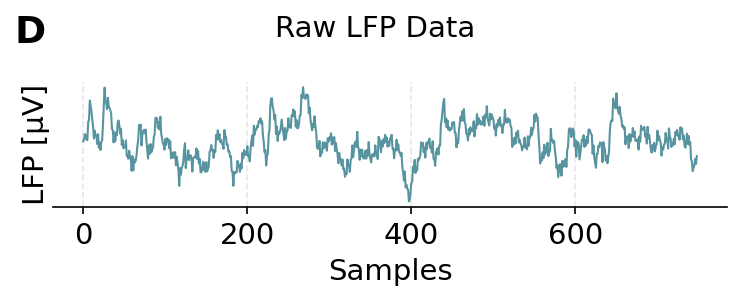

In [18]:
fig, ax = plt.subplots(figsize=(5, 2))

# ax.plot(dbs_times, dbs_selected_data, color=DBS_COLOR)
ax.plot(dbs_sample_indices, dbs_selected_data, color=DBS_COLOR)
# ax.plot(dbs_sample_indices, dbs_selected_data_filt, color=DBS_COLOR)
ax.set_ylabel('LFP [μV]', rotation=90, labelpad=1, fontsize=14, ha="center")

# Remove y-ticks
ax.set_yticks([])

# xticks fontsize 14
ax.tick_params(axis='x', labelsize=14)

# Hide all spines except bottom
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(True, linestyle="--", alpha=0.3)  # optional grid

# ax.set_xlabel("Time (s)")
ax.set_xlabel("Samples", fontsize=14)
fig.suptitle("Raw LFP Data", fontsize=14)

# add capital letter D to top left
fig.text(0.02, 0.98, 'D', transform=fig.transFigure, fontsize=18, fontweight='bold', va='top', ha='left')

plt.tight_layout()

# save plot as pdf in outputs/plots
plt.savefig(f"outputs/plots/fig6d_raw_dbs.pdf")
plt.show()


### 2. EEG Power Calculation

In [19]:
# Power for ['Pz', 'Cz', 'Fz', 'POz', 'CPz'] of complete signal (eeg_data_ch_selected)

# _, _, _, _, power_Pz = detect_eeg_sync_artifact(eeg_data_ch_selected, freq_low=120, freq_high=130, channel_list=['Pz'], plot=False, save_dir=None, sub_id=sub_id, block=block)
_, _, _, _, power_Cz = detect_eeg_sync_artifact(eeg_data_ch_selected, freq_low=120, freq_high=130, channel_list=['Cz'], plot=False, save_dir=None, sub_id=sub_id, block=block)
_, _, _, _, power_Fz = detect_eeg_sync_artifact(eeg_data_ch_selected, freq_low=120, freq_high=130, channel_list=['Fz'], plot=False, save_dir=None, sub_id=sub_id, block=block)
best_channel, eeg_sync_idx, eeg_sync_s, best_result,  power_post = detect_eeg_sync_artifact(eeg_data_ch_selected, freq_low=120, freq_high=130, channel_list=['POz'], plot=False, save_dir=None, sub_id=sub_id, block=block)
# _, _, _, _, power_CPz = detect_eeg_sync_artifact(eeg_data_ch_selected, freq_low=120, freq_high=130, channel_list=['CPz'], plot=False, save_dir=None, sub_id=sub_id, block=block)

# power_all = [power_Pz, power_Cz, power_Fz, power_post, power_CPz]

power_all = [power_Cz, power_Fz, power_post]
power_time = best_result["power_time"]
power_samples_indices = np.arange(len(power_time))

EEG power still sampled with 2000Hz

Fig. 6b

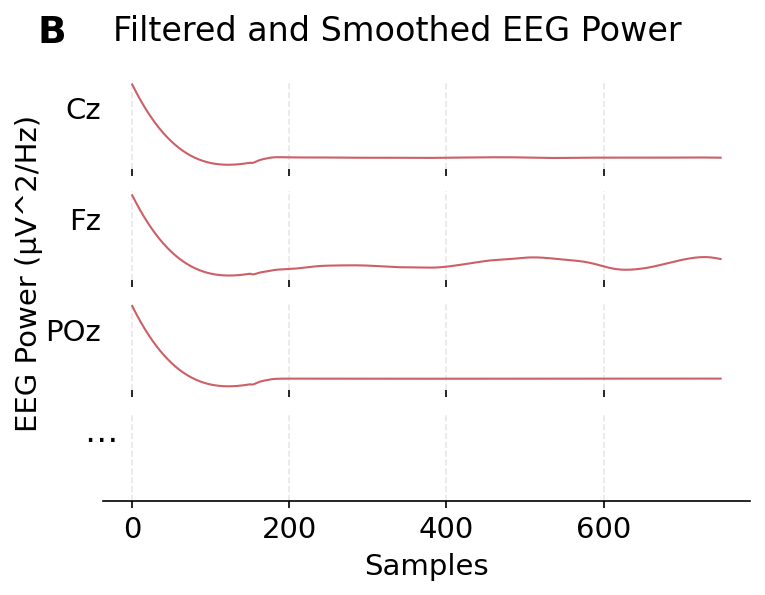

In [20]:
# plot the power for each channel

# Keep ~750 samples from the start
power_all = np.array(power_all)  # Convert list to array
power_all_cut = power_all[:, :750]
power_samples_indices = np.arange(power_all_cut.shape[1])

# Get number of channels
n_channels = power_all_cut.shape[0]

# Plot with one extra empty subplot
fig, axes = plt.subplots(n_channels + 1, 1, figsize=(5, n_channels + 1), sharex=True)

for i in range(n_channels):
    ax = axes[i]
    ax.plot(power_samples_indices, power_all_cut[i], color=EEG_COLOR)
    ax.set_ylabel(eeg_data_ch_selected.ch_names[i], rotation=0, labelpad=1, fontsize=14, ha="right")
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    if i != n_channels:
        ax.spines['bottom'].set_visible(False)
    ax.grid(True, linestyle="--", alpha=0.3)

# Add empty subplot
axes[-1].set_ylabel("⋯", rotation=0, labelpad=1, fontsize=16, ha="center")
axes[-1].set_yticks([])
axes[-1].spines['top'].set_visible(False)
axes[-1].spines['right'].set_visible(False)
axes[-1].spines['left'].set_visible(False)
axes[-1].spines['bottom'].set_visible(True)
axes[-1].grid(linestyle="--", alpha=0.3)

axes[-1].tick_params(axis='x', labelsize=14)
# set xticks to 0, 200, 400, 600
axes[-1].set_xticks([0, 200, 400, 600])
axes[-1].set_xlabel("Samples", fontsize=14)
fig.suptitle("Filtered and Smoothed EEG Power", fontsize=16)
plt.tight_layout()

# Shared y-label
fig.text(-0.01, 0.55, "EEG Power (μV^2/Hz)", va='center', rotation='vertical', fontsize=14)

# Add capital letter B to top left
fig.text(0.02, 0.98, 'B', transform=fig.transFigure, fontsize=18, fontweight='bold', va='top', ha='left')

# save plot as pdf in outputs/plots
plt.savefig(f"outputs/plots/fig6b_eeg_power.pdf", bbox_inches='tight')
plt.show()


### 3. Artifact Selection

Fig. 6c - best for P4-2008

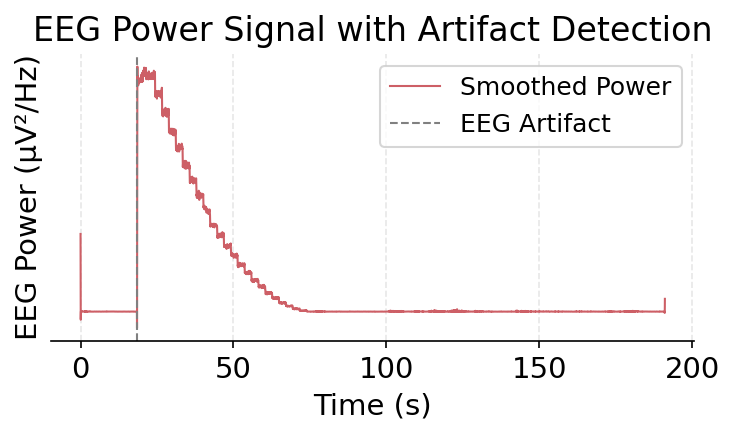

In [21]:
# plot eeg artifact with the sync artifact

best_power_smoothed = power_post

# Create time vector based on sampling frequency and start time
eeg_time_vector = np.arange(len(best_power_smoothed)) / fs_eeg_org + 0
eeg_sample_indices = np.arange(len(best_power_smoothed))

best_eeg_power_smoothed_cut = best_power_smoothed
eeg_power_time_vector_cut = eeg_time_vector
eeg_sample_indices_cut = eeg_sample_indices

#  cut the first samples and last samples as they have a big artifact
# best_eeg_power_smoothed_cut = best_power_smoothed[100:-100]
# eeg_power_time_vector_cut = eeg_time_vector[100:-100]
# eeg_sample_indices_cut = eeg_sample_indices[100:-100]

sync_time = best_result["onset_time"]
sync_idx = best_result["onset_index"]

plt.figure(figsize=(5, 3))
# Plot line
plt.plot(eeg_power_time_vector_cut, best_eeg_power_smoothed_cut, label="Smoothed Power", color=EEG_COLOR)
# plt.plot(eeg_sample_indices_cut, best_eeg_power_smoothed_cut, label="Smoothed Power", color=EEG_COLOR)  # for samples

# Sync artifact
plt.axvline(sync_time, color="grey", linestyle="--", label=f"EEG Artifact")
# plt.axvline(sync_idx, color="grey", linestyle="--", label=f"EEG Artifact: {sync_idx} samples")

# Styling
plt.ylabel("EEG Power (μV²/Hz)", fontsize=14)
plt.xlabel("Time (s)", fontsize=14)  # change to "Samples" if using index
plt.title(f"EEG Power Signal with Artifact Detection", fontsize=16)

# Hide spines except bottom
for spine in ['top', 'right', 'left']:
    plt.gca().spines[spine].set_visible(False)

# yticks empty
plt.yticks([])
# fontsize 14
plt.tick_params(axis='x', labelsize=14)

plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(fontsize=12, loc='upper right')

plt.tight_layout()
# save plot as pdf in outputs/plots
plt.savefig(f"outputs/plots/fig6c_eeg_power_artifact.pdf")
plt.show()

Fig. 6e

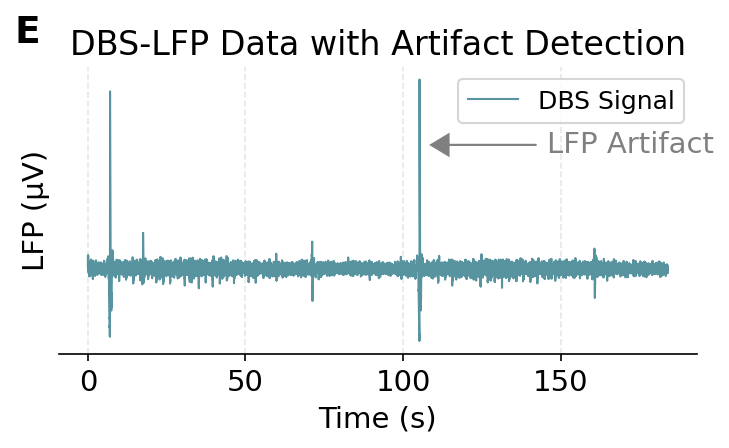

In [22]:
# Find DBS sync artifact
dbs_signal =  dbs_data["TimeDomainData"].values

# filter the dbs signal from 1-100 Hz
dbs_signal = bandpass_filter(dbs_signal, fs=dbs_fs, lowcut=1, highcut=100)


dbs_fs = dbs_data["SampleRateInHz"][0]
dbs_peak_idx, dbs_peak_s = detect_dbs_sync_artifact(dbs_signal, dbs_fs, save_dir=None, sub_id=sub_id, block=block)

# plot again in publication style
dbs_time_axis = np.arange(len(dbs_signal)) / dbs_fs

plt.figure(figsize=(5, 3))

# Plot DBS signal
plt.plot(dbs_time_axis, dbs_signal, label="DBS Signal", color=DBS_COLOR)
# plt.plot(np.arange(len(dbs_signal)), dbs_signal, label="DBS Signal", color=DBS_COLOR)  # for samples

# Mark detected artifact
# plt.axvline(dbs_time_axis[dbs_peak_idx], color='grey', linestyle='--', label=f'DBS Artifact')
# plt.axvline(dbs_peak_idx, color='grey', linestyle='--', label=f'DBS Artifact: {dbs_peak_idx} samples')

# add an arrow at the detected artifact in the upper third, pointing horizontally
y_max = dbs_signal.max()
y_min = dbs_signal.min()
y_range = y_max - y_min
x_range = dbs_time_axis[-1] - dbs_time_axis[0]  # total time range

# Position arrow to the right of the artifact
x_offset = 0.2 * x_range  # Move arrow start 20% of x-range to the right
arrow_x_start = dbs_time_axis[dbs_peak_idx] + x_offset
arrow_y_start = y_min + 0.75 * y_range  # Position at 75% of the height

# Arrow pointing horizontally left towards the artifact
arrow_length = 0.15 * x_range  # Arrow length in x direction
arrow_dx = -arrow_length  # negative to point left
arrow_dy = 0  # horizontal arrow (no vertical component)

plt.arrow(arrow_x_start, arrow_y_start, arrow_dx, arrow_dy, 
          head_width=0.08*y_range, head_length=0.03*x_range, fc='grey', ec='grey')
# label the arrow with "artifact" to the right of the arrow
plt.text(arrow_x_start + 0.02*x_range, arrow_y_start, 
         'LFP Artifact', fontsize=14, color='grey', ha='left', va='center')

# Labels and style
plt.xlabel('Time (s)', fontsize=14)  # change to 'Samples' if using index
plt.ylabel('LFP (μV)', fontsize=14)
plt.title('DBS-LFP Data with Artifact Detection', fontsize=16)

# Clean spines
for spine in ['top', 'right', 'left']:
    plt.gca().spines[spine].set_visible(False)

# xticks fontsize 14
plt.tick_params(axis='x', labelsize=14)

plt.yticks([])
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(fontsize=12, loc='upper right')

# Add capital letter E to top left
plt.gcf().text(0.02, 0.98, 'E', transform=plt.gcf().transFigure, fontsize=18, fontweight='bold', va='top', ha='left')


plt.tight_layout()
# save plot as pdf in outputs/plots
plt.savefig(f"outputs/plots/fig6e_dbs_artifact.pdf")

plt.show()


### 4. Get samples around artifact and plot

Fig. 3a (spike)

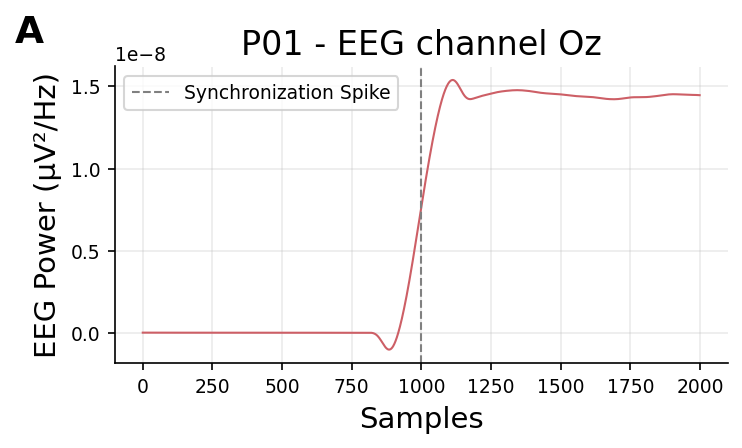

In [23]:
# Drop
if sub_id == "P4-2001":
    # plot the signal around the artifact: 
    eeg_power_artifact_clean = best_power_smoothed[eeg_sync_idx - fs_eeg_org//2:eeg_sync_idx + fs_eeg_org//2]

    plt.figure(figsize=(5, 3))
    plt.plot(eeg_power_artifact_clean, color=EEG_COLOR)
    plt.axvline(1000, color='grey', linestyle='--', label=f'Synchronization Spike')
    plt.ylabel('EEG Power (μV²/Hz)', fontsize=14)
    plt.xlabel('Samples', fontsize=14)
    plt.title('P01 - EEG channel Oz', fontsize=16)
    # add capital letter B to top left
    plt.gcf().text(0.02, 0.98, 'A', transform=plt.gcf().transFigure, fontsize=18, fontweight='bold', va='top', ha='left')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"outputs/plots/fig3a_eeg_power_artifact_spike.pdf")

    plt.show()

Fig. 3b (drop)


In [24]:
# Spike
if sub_id == "P4-2004":
    eeg_power_artifact_clean = best_power_smoothed[eeg_sync_idx - fs_eeg_org//2:eeg_sync_idx + fs_eeg_org//2]

    plt.figure(figsize=(5, 3))
    plt.plot(eeg_power_artifact_clean, color=EEG_COLOR)
    plt.axvline(1000, color='grey', linestyle='--', label=f'Synchronization Drop')
    plt.ylabel('EEG Power (μV²/Hz)', fontsize=14)
    plt.xlabel('Samples', fontsize=14)
    plt.title('P04 - EEG channel Oz', fontsize=16)
    # add capital letter A to top left
    plt.gcf().text(0.02, 0.98, 'B', transform=plt.gcf().transFigure, fontsize=18, fontweight='bold', va='top', ha='left')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"outputs/plots/fig3b_eeg_power_artifact_drop.pdf")

    plt.show()
    

In [25]:
# first resample the eeg power to the dbs sampling rate

# Resample (downsample by factor 8)
eeg_power_resampled = resample_poly(best_power_smoothed, up=dbs_fs, down=fs_eeg_org)

In [26]:
# print the length of the downssampled eeg in seconds and samples
print(f'Length of downsampled eeg: {len(eeg_power_resampled)/dbs_fs} seconds')
print(f'Length of downsampled eeg: {len(eeg_power_resampled)} samples')

Length of downsampled eeg: 191.072 seconds
Length of downsampled eeg: 47768 samples


In [27]:
# resample the sync index
eeg_sync_idx = int(best_result["index"])
eeg_sync_idx_resampled = int(eeg_sync_idx * dbs_fs / fs_eeg_org)
print(f'Sync index downsampled: {eeg_sync_idx_resampled} samples')
print(f'Sync index downsampled: {eeg_sync_idx_resampled/dbs_fs} seconds')

Sync index downsampled: 4630 samples
Sync index downsampled: 18.52 seconds


In [28]:
# extract the smoothed_power samples around +- 0.5s around the resampled artifact

eeg_power_artifact = eeg_power_resampled[eeg_sync_idx_resampled - dbs_fs//2 : eeg_sync_idx_resampled + dbs_fs//2]
eeg_times_artifact = np.arange(len(eeg_power_artifact)) / dbs_fs

print(eeg_power_artifact.shape)
print(eeg_times_artifact.shape)

(250,)
(250,)


In [29]:
# get the DBS artifact
dbs_artifact = dbs_signal[dbs_peak_idx-int(dbs_fs/2):dbs_peak_idx+int(dbs_fs/2)]
dbs_times = np.linspace(0, 1.0, len(dbs_artifact))

Fig. 6f

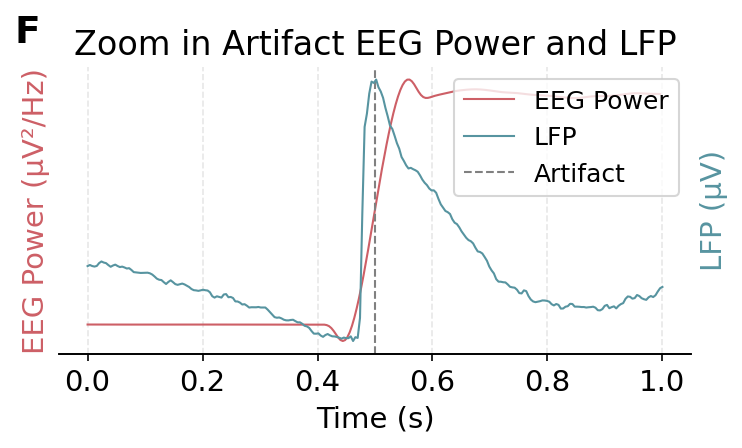

In [30]:
fig, ax1 = plt.subplots(figsize=(5, 3))

# EEG power on primary y-axis
eeg_line, = ax1.plot(eeg_times_artifact, eeg_power_artifact, color=EEG_COLOR, label='EEG Power')
ax1.set_ylabel('EEG Power (μV²/Hz)', fontsize=14, color=EEG_COLOR)
ax1.set_xlabel('Time (s)', fontsize=14)
ax1.set_title(f'Zoom in Artifact EEG Power and LFP', fontsize=16)

# DBS LFP on secondary y-axis
ax2 = ax1.twinx()
dbs_line, = ax2.plot(dbs_times, dbs_artifact, color=DBS_COLOR, label='LFP')
ax2.set_ylabel('LFP (μV)', fontsize=14, color=DBS_COLOR)
ax2.set_yticks([])

# Vertical line for sync artifact
artifact_line = ax1.axvline(0.5, color='grey', linestyle='--', label='Artifact')

# Styling: remove spines and y-ticks (left)
for ax in [ax1, ax2]:
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)

ax1.set_yticks([])
ax1.grid(True, linestyle="--", alpha=0.3)

# xticks fontsize 14
ax1.tick_params(axis='x', labelsize=14)

# Legend combining both axes
lines = [eeg_line, dbs_line, artifact_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, fontsize=12, loc='upper right')

plt.tight_layout()

# Add capital letter F to top left
fig.text(0.02, 0.98, 'F', transform=fig.transFigure, fontsize=18, fontweight='bold', va='top', ha='left')

# save plot as pdf in outputs/plots
plt.savefig(f"outputs/plots/fig6f_eeg_dbs_artifact.pdf")

plt.show()

### 5. Crop and align time series

In [31]:
# get eeg_data_ch_selected data for "best_channel"
data_2d, times = eeg_data_ch_selected.get_data(picks=[best_channel], return_times=True)
eeg_data_best_channel = data_2d[0]  # shape (n_times,)

In [32]:
# crop data at sync

cropped_eeg, cropped_dbs = cut_data_at_sync(
    eeg_raw=eeg_data_ch_selected,
    dbs_df=dbs_data,
    eeg_sync_idx=int(eeg_sync_idx),
    dbs_sync_idx=int(dbs_peak_idx)
)
# synchronize data
synchronized_eeg, synchronized_dbs = synchronize_data(
    cropped_eeg, cropped_dbs,
    resample_data=True,
    save_dir=None,          # or "outputs/plots" if you want the overlay figure saved
    sub_id=sub_id, block=block,
)

In [33]:
# get the best_channel from the synchronized_eeg
synchronized_eeg_1ch = synchronized_eeg.get_data(picks=[best_channel])[0]

In [34]:
# plot the synchronized data up until 120 seconds
# Use the minimum length to ensure both signals have the same number of samples
min_length = min(len(synchronized_eeg_1ch), len(synchronized_dbs["TimeDomainData"]), 120*dbs_fs)
synchronized_eeg_1ch_cropped = synchronized_eeg_1ch[0:min_length]
synchronized_dbs_cropped = synchronized_dbs["TimeDomainData"][0:min_length]
synced_eeg_times = np.arange(len(synchronized_eeg_1ch_cropped)) / dbs_fs

Fig. 6g

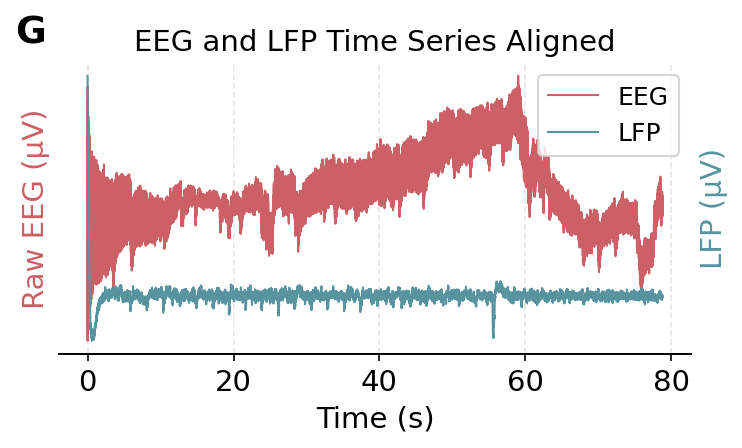

In [35]:
fig, ax1 = plt.subplots(figsize=(5, 3))

# EEG signal
eeg_line, = ax1.plot(synced_eeg_times, synchronized_eeg_1ch_cropped, color=EEG_COLOR, label='EEG')
ax1.set_ylabel('Raw EEG (μV)', fontsize=14, color=EEG_COLOR)
ax1.set_xlabel('Time (s)', fontsize=14)
ax1.set_title(f'EEG and LFP Time Series Aligned', fontsize=14)

# DBS signal
ax2 = ax1.twinx()
dbs_line, = ax2.plot(synced_eeg_times, synchronized_dbs_cropped, color=DBS_COLOR, label='LFP')
ax2.set_ylabel('LFP (μV)', fontsize=14, color=DBS_COLOR)

# Clean spines and ticks
for ax in [ax1, ax2]:
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])

ax1.grid(True, linestyle="--", alpha=0.3)

# xticks fontsize 14
ax1.tick_params(axis='x', labelsize=14)

# Combine legends
lines = [eeg_line, dbs_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right', fontsize=12)

plt.tight_layout()

# Add capital letter G to top left
fig.text(0.02, 0.98, 'G', transform=fig.transFigure, fontsize=18, fontweight='bold', va='top', ha='left')

# save plot as pdf in outputs/plots
plt.savefig(f"outputs/plots/fig6g_eeg_dbs.pdf")
plt.show()

### Channel Comparison: Oz vs AFz Artifact Amplitude


In [36]:
# print sub_id
print(sub_id)
# print available channels
print(eeg_data.ch_names)

P4-2001
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'AFz', 'Fz', 'Cz', 'Pz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'FT9', 'FT10', 'TP7', 'TP8', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP9', 'TP10', 'PO7', 'PO8', 'PO9', 'PO10', 'CPz', 'POz']


In [37]:
# Select Oz and AFz channels from the full EEG data
# pick channels
ch_posterior = 'C1'
ch_frontal = 'F1'
eeg_data_post_front = eeg_data.copy().pick_channels([ch_posterior, ch_frontal])

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [38]:
# Compute power for Oz channel
if sub_id == 'P4-2007':
    channel_post, eeg_sync_idx_post, eeg_sync_s_post, result_post, power_post = detect_eeg_sync_artifact(
        eeg_data_post_front, freq_low=110, freq_high=120, channel_list=[ch_posterior], 
        plot=False, save_dir=None, sub_id=sub_id, block=block
    )
else:
    channel_post, eeg_sync_idx_post, eeg_sync_s_post, result_post, power_post = detect_eeg_sync_artifact(
        eeg_data_post_front, freq_low=120, freq_high=130, channel_list=[ch_posterior], 
        plot=False, save_dir=None, sub_id=sub_id, block=block
    )

# Compute power for AFz channel
if sub_id == 'P4-2007':
    channel_front, eeg_sync_idx_front, eeg_sync_s_front, result_front, power_front = detect_eeg_sync_artifact(
        eeg_data_post_front, freq_low=110, freq_high=120, channel_list=[ch_frontal], 
        plot=False, save_dir=None, sub_id=sub_id, block=block
    )
else:
    channel_front, eeg_sync_idx_front, eeg_sync_s_front, result_front, power_front = detect_eeg_sync_artifact(
        eeg_data_post_front, freq_low=120, freq_high=130, channel_list=[ch_frontal], 
        plot=False, save_dir=None, sub_id=sub_id, block=block
    )


In [39]:
# Extract artifact region for Oz channel (±0.5s around artifact)
eeg_power_artifact_post = power_post[eeg_sync_idx_post - int(sfreq/2) : eeg_sync_idx_post + int(sfreq/2)]
eeg_times_artifact_post = np.arange(len(eeg_power_artifact_post)) / sfreq

# Extract artifact region for AFz channel (±0.5s around artifact)
eeg_power_artifact_front = power_front[eeg_sync_idx_front - int(sfreq/2) : eeg_sync_idx_front + int(sfreq/2)]
eeg_times_artifact_front = np.arange(len(eeg_power_artifact_front)) / sfreq

print(f"{ch_posterior} artifact detected at: {eeg_sync_idx_post} samples ({eeg_sync_s_post:.3f} s)")
print(f"{ch_frontal} artifact detected at: {eeg_sync_idx_front} samples ({eeg_sync_s_front:.3f} s)")
print(f"{ch_posterior} peak artifact amplitude: {np.max(eeg_power_artifact_post):.2f}")
print(f"{ch_frontal} peak artifact amplitude: {np.max(eeg_power_artifact_front):.2f}")
print(f"Amplitude ratio ({ch_posterior}/{ch_frontal}): {np.max(eeg_power_artifact_post) / np.max(eeg_power_artifact_front):.2f}x")


C1 artifact detected at: 37046 samples (18.523 s)
F1 artifact detected at: 228996 samples (114.498 s)
C1 peak artifact amplitude: 0.00
F1 peak artifact amplitude: 0.00
Amplitude ratio (C1/F1): 2.82x


**Overlay plot**: Both channels on the same axes for direct comparison

In [40]:
EEG_COLOR
EEG_COLOR_light = '#E4929780'

Fig1: choose P4-2001 + baseline for publication plot with channel C1 and F1

**Stacked plot:** side-by-side with peak amplitude annotations

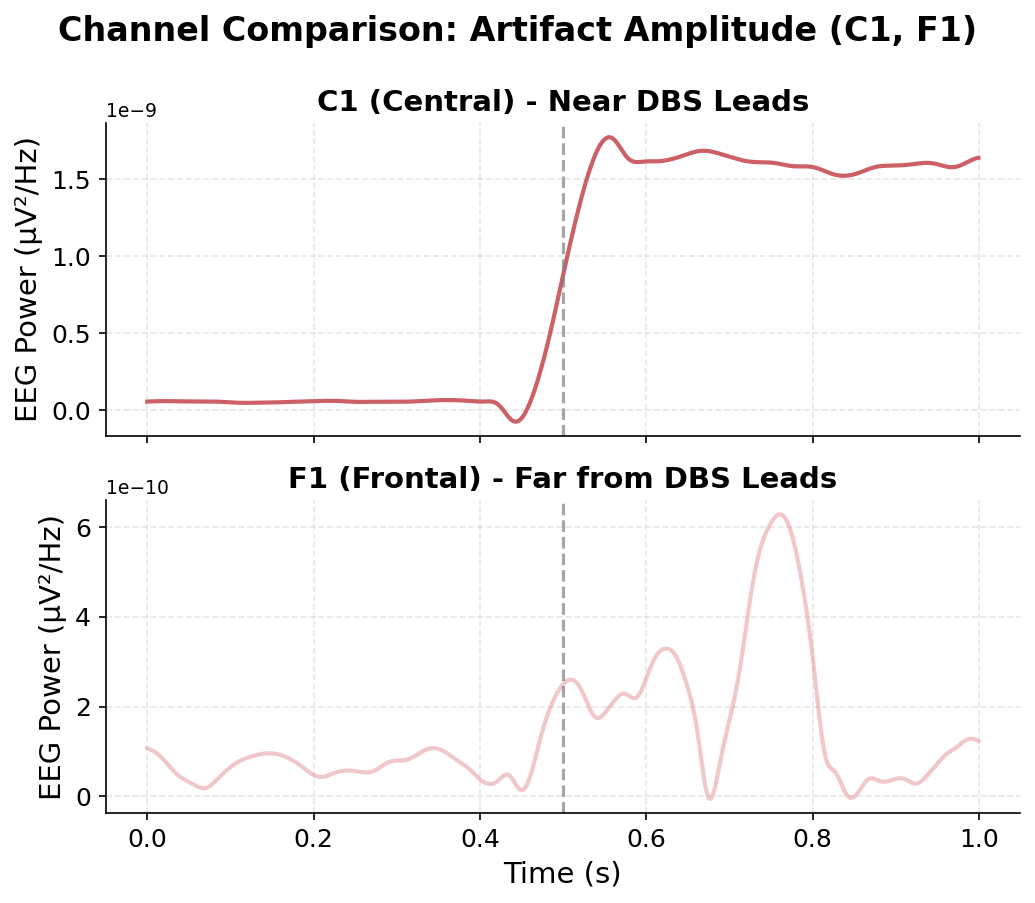

In [41]:
# Plot comparison: Oz vs AFz side by side
fig, axes = plt.subplots(2, 1, figsize=(7, 6), sharex=True)

# Oz channel (top)
axes[0].plot(eeg_times_artifact_post, eeg_power_artifact_post, color=EEG_COLOR, linewidth=2)
axes[0].axvline(0.5, color='grey', linestyle='--', linewidth=1.5, alpha=0.7)
axes[0].set_ylabel('EEG Power (μV²/Hz)', fontsize=14)
axes[0].set_title(f'{ch_posterior} (Central) - Near DBS Leads', fontsize=14, fontweight='bold')
axes[0].grid(True, linestyle="--", alpha=0.3)
axes[0].tick_params(axis='y', labelsize=12)

# # Add max amplitude annotation
# max_post = np.max(eeg_power_artifact_post)
# max_idx_post = np.argmax(eeg_power_artifact_post)
# axes[0].annotate(f'Peak: {max_post:.1f}', 
#                 xy=(eeg_times_artifact_post[max_idx_post], max_post),
#                 xytext=(10, 10), textcoords='offset points',
#                 fontsize=11, color=EEG_COLOR,
#                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=EEG_COLOR, alpha=0.8))

# AFz channel (bottom)
axes[1].plot(eeg_times_artifact_front, eeg_power_artifact_front, color=EEG_COLOR_light, linewidth=2)
axes[1].axvline(0.5, color='grey', linestyle='--', linewidth=1.5, alpha=0.7, label='Sync Artifact')
axes[1].set_ylabel('EEG Power (μV²/Hz)', fontsize=14)
axes[1].set_xlabel('Time (s)', fontsize=14)
axes[1].set_title(f'{ch_frontal} (Frontal) - Far from DBS Leads', fontsize=14, fontweight='bold')
axes[1].grid(True, linestyle="--", alpha=0.3)
axes[1].tick_params(axis='both', labelsize=12)

# # Add max amplitude annotation
# max_front = np.max(eeg_power_artifact_front)
# max_idx_front = np.argmax(eeg_power_artifact_front)
# axes[1].annotate(f'Peak: {max_front:.1f}', 
#                 xy=(eeg_times_artifact_front[max_idx_front], max_front),
#                 xytext=(10, 10), textcoords='offset points',
#                 fontsize=11, color=EEG_COLOR_light,
#                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=EEG_COLOR_light, alpha=0.8))

# Clean spines for both
for ax in axes:
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

# Overall title
# fig.suptitle(f'Channel Comparison: Artifact Amplitude ({ch_posterior}/{ch_frontal} ratio: {max_post/max_front:.2f}x)',
fig.suptitle(f'Channel Comparison: Artifact Amplitude ({ch_posterior}, {ch_frontal})', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
# plt.savefig(f"outputs/plots/fig_channel_comparison_post_vs_front_stacked.pdf", bbox_inches='tight')
plt.show()
